In [1]:
import os
import cv2
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from skimage import io
from skimage.transform import rescale, resize, ProjectiveTransform, warp, hough_line, hough_line_peaks
%matplotlib inline
from skimage.morphology import dilation, disk
from skimage.feature import canny, match_template

In [2]:
import numpy as np

def matrix_to_puzzle(matrix):
    rows = [' {}  {}  {} | {}  {}  {} | {}  {}  {}'.format(*x).replace('0', '.') for x in matrix]
    rows.insert(6, '---------+---------+---------')
    rows.insert(3, '---------+---------+---------')
    return '\n'.join(rows)

def puzzle_to_matirx(puzzle):
    vector = [x for x in puzzle.values()]
    return np.array(vector).astype(int).reshape([9, 9])

def solve_sudoku(sudoku_matrix):
    puzzle = matrix_to_puzzle(sudoku_matrix)
    try:
        solution = solve_puzzle(puzzle)
    except TypeError as e:
        raise ValueError('An error in sudoku solving engine. Please check your CV algorithm!') from None
    return puzzle_to_matirx(solution)

################### The code above converts matrix to string and back

################### The code below is taken from https://medium.com/@neshpatel/solving-sudoku-part-i-7c4bb3097aa7


def sudoku_reference():
    """Gets a tuple of reference objects that are useful for describing the Sudoku grid."""
    
    def cross(str_a, str_b):
        """Cross product (concatenation) of two strings A and B."""
        return [a + b for a in str_a for b in str_b]

    all_rows = 'ABCDEFGHI'
    all_cols = '123456789'

    # Build up list of all cell positions on the grid
    coords = cross(all_rows, all_cols)
    # print(len(coords))  # 81

    # Get the units for each row
    row_units = [cross(row, all_cols) for row in all_rows]
    # print(row_units[0])  # ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9']

    # Do it in reverse to get the units for each column
    col_units = [cross(all_rows, col) for col in all_cols]
    # print(col_units[0])  # ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1']

    box_units = [cross(row_square, col_square) for row_square in ['ABC', 'DEF', 'GHI'] for col_square in ['123', '456', '789']]
    # print(box_units[0])   # ['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'C1', 'C2', 'C3']

    all_units = row_units + col_units + box_units  # Add units together
    groups = {}

    # For each cell, get the each unit that the cell is part of (3 per cell)
    groups['units'] = {pos: [unit for unit in all_units if pos in unit] for pos in coords}
    # print(units['A1'])  # 3 Units of length 9 for each cell

    # For each cell get the list of peers to that position
    groups['peers'] = {pos: set(sum(groups['units'][pos], [])) - {pos} for pos in coords}
    # print(peers['A1'])  # Peer cells for the position, length 20 for each cell
    
    return coords, groups, all_units


def parse_puzzle(puzzle, digits='123456789', nulls='0.'):
    """
    Parses a string describing a Sudoku puzzle board into a dictionary with each cell mapped to its relevant
    coordinate, i.e. A1, A2, A3...
    """

    # Serialise the input into a string, let the position define the grid location and .0 can be empty positions
    # Ignore any characters that aren't digit input or nulls
    flat_puzzle = ['.' if char in nulls else char for char in puzzle if char in digits + nulls]

    if len(flat_puzzle) != 81:
        raise ValueError('Input puzzle has %s grid positions specified, must be 81. Specify a position using any '
                         'digit from 1-9 and 0 or . for empty positions.' % len(flat_puzzle))

    coords, groups, all_units = sudoku_reference()

    # Turn the list into a dictionary using the coordinates as the keys
    return dict(zip(coords, flat_puzzle))

def validate_sudoku(puzzle):
    """Checks if a completed Sudoku puzzle has a valid solution."""
    
    if puzzle is None:
        return False
      
    coords, groups, all_units = sudoku_reference()
    full = [str(x) for x in range(1, 10)]  # Full set, 1-9 as strings
    
    # Checks if all units contain a full set
    return all([sorted([puzzle[cell] for cell in unit]) == full for unit in all_units])


def solve_puzzle(puzzle):
    """Solves a Sudoku puzzle from a string input."""
    digits = '123456789'  # Using a string here instead of a list

    coords, groups, all_units = sudoku_reference()
    input_grid = parse_puzzle(puzzle)
    input_grid = {k: v for k, v in input_grid.items() if v != '.'}  # Filter so we only have confirmed cells
    output_grid = {cell: digits for cell in coords}  # Create a board where all digits are possible in each cell

    def confirm_value(grid, pos, val):
        """Confirms a value by eliminating all other remaining possibilities."""
        remaining_values = grid[pos].replace(val, '')  # Possibilities we can eliminate due to the confirmation
        for val in remaining_values:
            grid = eliminate(grid, pos, val)
        return grid

    def eliminate(grid, pos, val):
        """Eliminates `val` as a possibility from all peers of `pos`."""

        if grid is None:  # Exit if grid has already found a contradiction
            return None

        if val not in grid[pos]:  # If we have already eliminated this value we can exit
            return grid

        grid[pos] = grid[pos].replace(val, '')  # Remove the possibility from the given cell

        if len(grid[pos]) == 0:  # If there are no remaining possibilities, we have made the wrong decision
            return None
        elif len(grid[pos]) == 1:  # We have confirmed the digit and so can remove that value from all peers now
            for peer in groups['peers'][pos]:
                grid = eliminate(grid, peer, grid[pos])  # Recurses, propagating the constraint
                if grid is None:  # Exit if grid has already found a contradiction
                    return None

        # Check for the number of remaining places the eliminated digit could possibly occupy
        for unit in groups['units'][pos]:
            possibilities = [p for p in unit if val in grid[p]]

            if len(possibilities) == 0:  # If there are no possible locations for the digit, we have made a mistake
                return None
            # If there is only one possible position and that still has multiple possibilities, confirm the digit
            elif len(possibilities) == 1 and len(grid[possibilities[0]]) > 1:
                if confirm_value(grid, possibilities[0], val) is None:
                    return None

        return grid

    # First pass of constraint propagation
    for position, value in input_grid.items():  # For each value we're given, confirm the value
        output_grid = confirm_value(output_grid, position, value)

    if validate_sudoku(output_grid):  # If successful, we can finish here
        return output_grid

    def guess_digit(grid):
        """Guesses a digit from the cell with the fewest unconfirmed possibilities and propagates the constraints."""

        if grid is None:  # Exit if grid already compromised
            return None

        # Reached a valid solution, can end
        if all([len(possibilities) == 1 for cell, possibilities in grid.items()]):
            return grid

        # Gets the coordinate and number of possibilities for the cell with the fewest remaining possibilities
        n, pos = min([(len(possibilities), cell) for cell, possibilities in grid.items() if len(possibilities) > 1])

        for val in grid[pos]:
            # Run the constraint propagation, but copy the grid as we will try many adn throw the bad ones away.
            # Recursively guess digits until its complete and there's a valid solution
            solution = guess_digit(confirm_value(grid.copy(), pos, val))
            if solution is not None:
                return solution

    output_grid = guess_digit(output_grid)
    return output_grid

In [3]:
shape_sud = 500
ITEM_REDUCE_COEFF = 0.88

PATH_TO_TEMPLATES = 'templates'
IMG_FORMATS = ['jpg', 'jpeg', 'png']

def get_tform_points(current_points):
    """Return desired points for ProjectiveTransform."""
    
    #Firstly we should sort the corner's point
    current_points[:2] = np.array(sorted(current_points[:2], key=lambda x: x[1]))
    current_points[2:] = np.array(sorted(current_points[2:], key=lambda x: x[1]))

    a = current_points[:2][:, 0].mean()
    c = current_points[2:][:, 0].mean()
    b = current_points[::2][:, 1].mean()
    d = current_points[1::2][:, 1].mean()

    desired_points = [[a, b], [a, d], [c, b], [c, d]]
    desired_points = np.array(desired_points, dtype=np.int32)

    return desired_points


def find_corners(image):
    edges = canny(image)
    selem = disk(1)
    edges = dilation(edges, selem)
    
    edges = (edges).astype(np.uint8)
    ext_contours = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    contour = max(ext_contours, key=cv2.contourArea)
    contour = contour.squeeze()

    epsilon = 0.05 * cv2.arcLength(contour, True)
    corners = cv2.approxPolyDP(contour, epsilon, True).squeeze()

    return corners


def transform_image(image, corners):
    corners = sorted(corners, key=lambda x: x[0])
    corners = np.array(corners)

    desired_corners = get_tform_points(corners)

    tform = ProjectiveTransform()
    tform.estimate(desired_corners, corners)
    image_warped = warp(image, tform)

    return image_warped, desired_corners


def crop_image(image, corners):
    left, bot = corners.min(axis=0)
    right, top = corners.max(axis=0)

    image_cropped = image[bot: top, left:right]
    side = max(image_cropped.shape)

    image_cropped = resize(image_cropped, (side, side),
                           anti_aliasing=True)
    image_cropped = rescale(image_cropped, shape_sud/side)

    return image_cropped


def normalize_image(image):
    corners = find_corners(image)
    image_warped, desired_corners = transform_image(image, corners)
    image_cropped = crop_image(image_warped, desired_corners)
    return image_cropped


def get_sudoku_items(image):
    size_d = round(shape_sud/9)
    size_dig = round(size_d*ITEM_REDUCE_COEFF)
    shift = (size_d - size_dig) // 2
    sudoku = np.zeros((9, 9, size_dig, size_dig))

    for i in range(9):
        for j in range(9):
            digit_img = image[i*size_d:(i+1)*size_d, j*size_d:(j+1)*size_d].copy()
            digit_img = digit_img[shift: shift+size_dig, shift: shift+size_dig]

            threshold = np.median(digit_img)*0.9
            digit_img[digit_img>threshold] = 1
            sudoku[i, j] = digit_img

    return sudoku


def get_image_paths(path):
    is_img = lambda x: any(x.endswith(format) for format in IMG_FORMATS)

    files = os.listdir(path)
    files = map(str.lower, files)
    files = filter(is_img, files)
    image_paths = [os.path.join(path, s) for s in files]

    return image_paths


def load_templates():
    templates_paths = get_image_paths(PATH_TO_TEMPLATES)
    templates_paths.sort()

    templates = {i: [] for i in range(1, 10)}

    for i, t in enumerate(templates_paths):
        template = io.imread(t, as_gray=True)
        template = rescale(template, 0.95)
        templates[i//2+1].append(template)
    return templates


def find_max_digits_corr(digit, templates):
    max_digits_corr = np.zeros(9)
    for d, templs in templates.items():
        max_corr = 0
        for t in templs:
            res = match_template(digit, t)
            max_corr += res.max()
        max_digits_corr[d-1] = max_corr
        
    return max_digits_corr


def recognize_digits(image, threshold=1.2):
    sudoku = get_sudoku_items(image)
    templates = load_templates()

    digits = np.zeros((9, 9), dtype=np.int16)

    for i in range(9):
        for j in range(9):
            max_digits_corr = find_max_digits_corr(sudoku[i, j], templates)
            digits[i, j] = np.argmax(max_digits_corr) + 1 if max_digits_corr.max() > threshold else 0
    
    return digits

In [4]:
def fin_corners(image):
    
    edges = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,199,25)
    edges = (edges).astype(np.uint8)
    edges = cv2.copyMakeBorder(edges, 30, 30, 30, 30, cv2.BORDER_CONSTANT, value = 255)
    ext_contours, _ = cv2.findContours(edges.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)#0]
    contours = sorted(ext_contours, key = cv2.contourArea, reverse = True)
    contours_neeed = []
    for i in contours:
        x, y, w, h = cv2.boundingRect(i)
        ratio = float(w)/h
        if ratio >= 0.9 and ratio <= 1.1: 
            
            for iter_1, elem_1 in enumerate(i):
                for iter_2, elem_2 in enumerate(elem_1):
                    i[iter_1][iter_2] = elem_2 - 30
            
            contours_neeed.append(i)
            
    contours_final = []
    for i in contours_neeed:
        if cv2.contourArea(i) > 0.5 * cv2.contourArea(contours_neeed[0]):
            contours_final.append(i)
    
    newimg = cv2.drawContours(img.copy(), contours_final,-1,(0,255, 0),3)
    
    contours_square = []
    for cont in contours_final:
        cont = cont.squeeze()
        epsilon = 0.05 * cv2.arcLength(cont, True)
        corners = cv2.approxPolyDP(cont, epsilon, True).squeeze()
        contours_square.append(corners)

    return contours_square

In [5]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

In [6]:
def get_perspective(img, location, height = 500, width = 500):
 
    pts1 = np.float32([location[0], location[1], location[2], location[3]])
    pts2 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])

    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    result = cv2.warpPerspective(img, matrix, (width, height))
    return result

In [7]:
def predict_image(img):
    for picn in range(0,1):
        cntour = fin_corners(img[:,:,0])

        for i in cntour:
            x_s = sorted(i, key=lambda x: x[1])
            y_s = sorted(i, key=lambda x: x[0])

            x_s = [list(i) for i in x_s]
            y_s = [list(i) for i in y_s]

            ll = intersection(x_s[:2], y_s[:2])
            lu = intersection(x_s[:2], y_s[2:])
            rl = intersection(x_s[2:], y_s[:2])
            ru = intersection(x_s[2:], y_s[2:])

            ordered = [ll, lu, rl, ru]
    ordered_open = np.array([i[0] for i in ordered])
    ordered_open_ = np.array([list(ordered_open[0]), list(ordered_open[1]), list(ordered_open[3]),list(ordered_open[2])])
    mask = cv2.fillPoly(np.zeros(img.shape[:2]), pts = [ordered_open_], color=(1))
    
    plt.imshow(mask, cmap="gray")
    
    img = img[:,:,0]
    image_full = img
    image_scaled = rescale(image_full, 0.3)
    
    image_normalized = normalize_image(image_full)
    
    size_d = round(shape_sud/9)
    
    digits = recognize_digits(image_normalized)
    digits1 = recognize_digits(image_normalized)
    
    for i in range(9):
         for j in range(9):
                 if digits[i][j] == 0:
                        digits1[i][j]="-1"
    solution = solve_sudoku(digits)
    plt.figure(figsize=(18, 9))
    plt.imshow(image_normalized, cmap=cm.gray)
    print(digits1)
    for i in range(9):
        for j in range(9):
            if digits[i, j] == 0:
                plt.text((j)*size_d+10, (i+1)*size_d-12, str(solution[i, j]), fontdict={'size':40, 'color':'r'})
#     print(solution)
    return mask, digits1

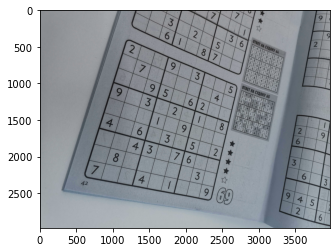

In [8]:
img = cv2.imread('train/train_3.jpg')
plt.imshow(img, cmap="gray")

[[ 2 -1 -1  9 -1  3 -1 -1  5]
 [-1  7 -1 -1 -1 -1 -1  4 -1]
 [-1 -1  9  5 -1  6  2 -1 -1]
 [ 9 -1  3 -1  2 -1  1 -1  8]
 [-1 -1 -1  1 -1  9 -1 -1 -1]
 [ 4 -1  6 -1  3 -1  5 -1  2]
 [-1 -1  4  3 -1  7  6 -1 -1]
 [-1  8 -1 -1 -1 -1 -1  3 -1]
 [ 7 -1 -1  4 -1  1 -1 -1  9]]


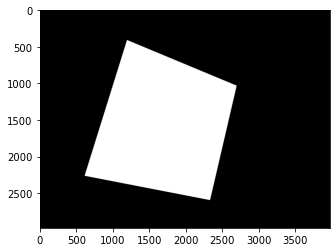

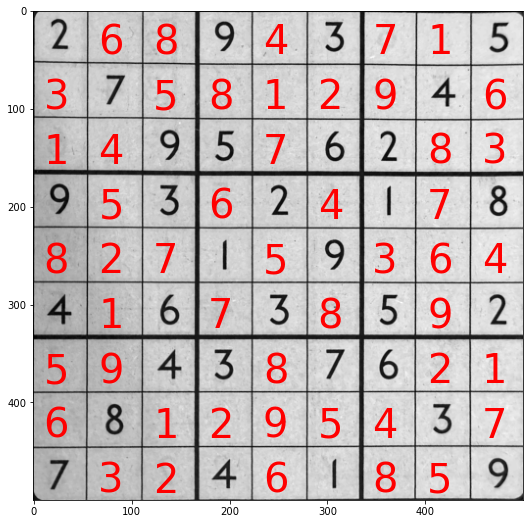

In [9]:
mask, digits = predict_image(img)

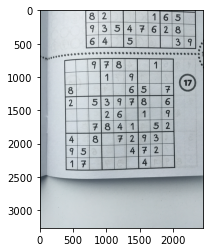

In [10]:
img = cv2.imread('train/train_7.jpg')
plt.imshow(img, cmap="gray")

[[-1 -1  9  7  8 -1 -1  1 -1]
 [-1 -1 -1  1 -1  9 -1 -1 -1]
 [ 8 -1 -1 -1 -1  6  5 -1  7]
 [ 2 -1  5  3  9  7  8 -1  6]
 [-1 -1 -1  2  6 -1  1 -1  9]
 [-1 -1  7  8  4  1 -1  5  2]
 [ 4 -1  8 -1  7  2  9  3 -1]
 [ 9  5 -1 -1 -1  4  7  2 -1]
 [ 1  7 -1 -1 -1 -1  4 -1 -1]]


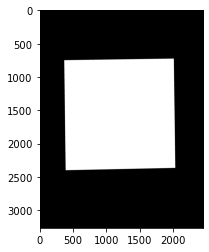

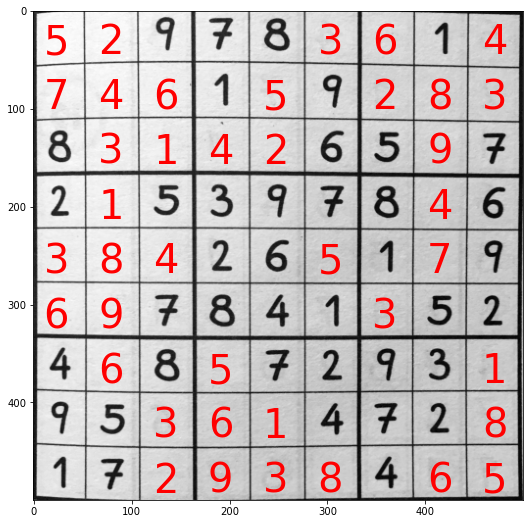

In [11]:
mask, digits = predict_image(img)

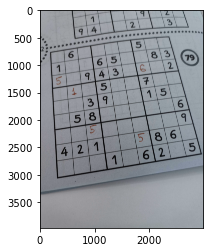

In [12]:
img = cv2.imread('train/train_4.jpg')
plt.imshow(img, cmap="gray")

[[-1  6 -1 -1 -1 -1  5 -1 -1]
 [ 1 -1 -1  6  5 -1 -1  8  3]
 [ 5 -1  9  4  3 -1 -1 -1  2]
 [-1 -1 -1  5 -1 -1  7 -1 -1]
 [-1 -1  3  9 -1 -1  1  5 -1]
 [-1  5  8 -1 -1 -1 -1 -1  6]
 [-1 -1 -1 -1 -1 -1 -1 -1  9]
 [ 4  2  1 -1 -1 -1  8  6 -1]
 [-1 -1 -1  1 -1  6  2 -1  5]]


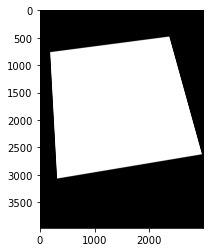

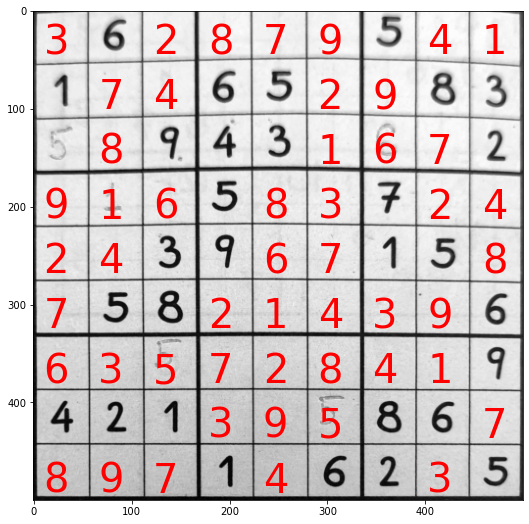

In [13]:
mask, digits = predict_image(img)